In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from lib import plot_util
import pandas as pd
import dowhy
from dowhy import CausalModel

import importlib

sns.set_theme()
%load_ext autoreload
%autoreload

# Identify Estimands

## Build Graph

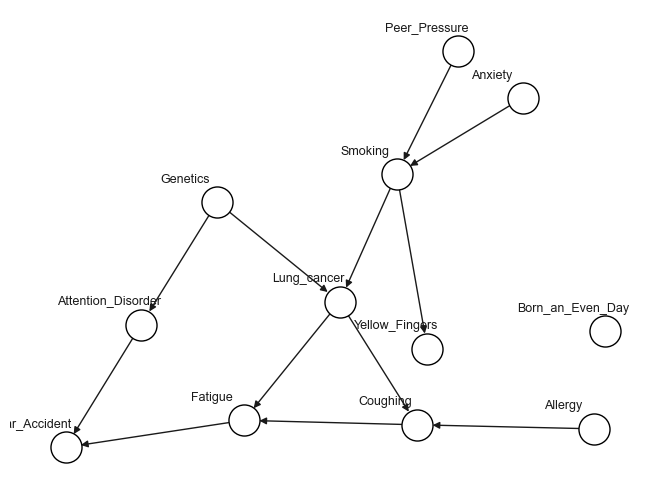

In [3]:
# import data
df_lucas0 = pd.read_csv("lucas0_train.csv")
nodes = df_lucas0.columns.values

# we import networkx and create a directed graph
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(
    [('Anxiety', 'Smoking'),
     ('Peer_Pressure', 'Smoking'),
     ('Smoking', 'Yellow_Fingers'), ('Smoking', 'Lung_cancer'),
     ('Lung_cancer', 'Coughing'), ('Lung_cancer', 'Fatigue'),
     ('Allergy', 'Coughing'),
     ('Coughing', 'Fatigue'),
     ('Fatigue', 'Car_Accident'),
     ('Attention_Disorder', 'Car_Accident'),
     ('Genetics', 'Attention_Disorder'), ('Genetics', 'Lung_cancer')])

pos = nx.kamada_kawai_layout(G)
pos = {
    **pos,
    "Born_an_Even_Day": [0.9, -0.2],
    "Yellow_Fingers": [pos["Yellow_Fingers"][0] + 0.2, pos["Yellow_Fingers"][1] - 0.2],
    "Anxiety": [pos["Anxiety"][0] + 0.2, pos["Anxiety"][1] - 0.2],
}
pos_labels = plot_util.nudge(pos, -0.1, 0.1)
nx.draw(G, pos=pos, node_size=500, node_color='w', edgecolors='black')
nx.draw_networkx_labels(G, pos=pos_labels, font_size=9, font_weight=10)
nx.write_gml(G, "lucas0_backdoor_criterion_graph.gml")

In [4]:
import dowhy
from dowhy import CausalModel

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

gml_graph = gml_to_string('lucas0_backdoor_criterion_graph.gml')

## Identity Estimands

####  Yellow_Fingers -> Lung_cancer

In [5]:
model=CausalModel(
        data = df_lucas0,
        treatment='Yellow_Fingers',
        outcome='Lung_cancer',
        graph=gml_graph
        )
identified_estimand = model.identify_effect()
print(identified_estimand)

No directed path from ['Yellow_Fingers'] to ['Lung_cancer'] in the causal graph.
Causal effect is zero.


In [6]:
identifier = model.identifier
identifier.identify_backdoor(model._graph, model._treatment, model._outcome)

[{'backdoor_set': ('Coughing',
   'Attention_Disorder',
   'Car_Accident',
   'Anxiety',
   'Fatigue',
   'Smoking',
   'Peer_Pressure',
   'Genetics')},
 {'backdoor_set': ('Smoking',)}]

In [7]:
identified_estimand = model.identify_effect()
print(identified_estimand)

No directed path from ['Yellow_Fingers'] to ['Lung_cancer'] in the causal graph.
Causal effect is zero.


#### Coughing -> Fatigue (coufounded by Lung Cancer)

In [20]:
model=CausalModel(
        data = df_lucas0,
        treatment='Coughing',
        outcome='Fatigue',
        graph=gml_graph
        )
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                             
───────────(E[Fatigue|Lung_cancer])
d[Coughing]                        
Estimand assumption 1, Unconfoundedness: If U→{Coughing} and U→Fatigue then P(Fatigue|Coughing,Lung_cancer,U) = P(Fatigue|Coughing,Lung_cancer)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d               ⎛    d                 ⎞  ⎥
E⎢──────────(Fatigue)⋅⎜──────────([Coughing])⎟  ⎥
 ⎣d[Allergy]          ⎝d[Allergy]            ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Fatigue then ¬(U →→{Allergy})
Estimand assumption 2, Exclusion: If we remove {Allergy}→{Coughing}, then ¬({Allergy}→Fatigue)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [21]:
identifier = model.identifier
identifier.identify_backdoor(model._graph, model._treatment, model._outcome)

[{'backdoor_set': ('Lung_cancer',
   'Attention_Disorder',
   'Anxiety',
   'Allergy',
   'Smoking',
   'Yellow_Fingers',
   'Peer_Pressure',
   'Genetics')},
 {'backdoor_set': ('Lung_cancer',)}]

In [22]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                             
───────────(E[Fatigue|Lung_cancer])
d[Coughing]                        
Estimand assumption 1, Unconfoundedness: If U→{Coughing} and U→Fatigue then P(Fatigue|Coughing,Lung_cancer,U) = P(Fatigue|Coughing,Lung_cancer)

## Realized estimand
b: Fatigue~Coughing+Lung_cancer
Target units: ate

## Estimate
Mean value: 0.35320927869781793

Causal Estimate is 0.35320927869781793


In [23]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                             
───────────(E[Fatigue|Lung_cancer])
d[Coughing]                        
Estimand assumption 1, Unconfoundedness: If U→{Coughing} and U→Fatigue then P(Fatigue|Coughing,Lung_cancer,U) = P(Fatigue|Coughing,Lung_cancer)

## Realized estimand
b: Fatigue~Coughing+Lung_cancer
Target units: ate

## Estimate
Mean value: 0.3507998093204842

Causal Estimate is 0.3507998093204842


In [24]:
# using the instrumental variables
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d               ⎛    d                 ⎞  ⎥
E⎢──────────(Fatigue)⋅⎜──────────([Coughing])⎟  ⎥
 ⎣d[Allergy]          ⎝d[Allergy]            ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Fatigue then ¬(U →→{Allergy})
Estimand assumption 2, Exclusion: If we remove {Allergy}→{Coughing}, then ¬({Allergy}→Fatigue)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡   d             ⎤  -1⎡   d              ⎤
E⎢────────(Fatigue)⎥⋅E  ⎢────────(Coughing)⎥
 ⎣dAllergy         ⎦    ⎣dAllergy          ⎦
Estimand assumption 1, As-if-random: If U→→Fatigue then ¬(U →→{Allergy})
Estimand assumption 2, Exclusion: If we remove {Allergy}→{Coughing}, then ¬({Allergy}→Fatigue)
Estimand assumption 3, treatment_effect_homoge

#### Allergy -> Car accident

Results are very weird should not have backdoor here !

In [34]:
model=CausalModel(
        data = df_lucas0,
        treatment='Allergy',
        outcome='Car_Accident',
        graph=gml_graph
        )
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                      
──────────(E[Car_Accident])
d[Allergy]                 
Estimand assumption 1, Unconfoundedness: If U→{Allergy} and U→Car_Accident then P(Car_Accident|Allergy,,U) = P(Car_Accident|Allergy,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [35]:
identifier = model.identifier
identifier.identify_backdoor(model._graph, model._treatment, model._outcome)

[{'backdoor_set': set()},
 {'backdoor_set': ('Lung_cancer',
   'Attention_Disorder',
   'Anxiety',
   'Smoking',
   'Yellow_Fingers',
   'Peer_Pressure',
   'Genetics')},
 {'backdoor_set': ('Lung_cancer',)},
 {'backdoor_set': ('Attention_Disorder',)},
 {'backdoor_set': ('Anxiety',)},
 {'backdoor_set': ('Smoking',)},
 {'backdoor_set': ('Yellow_Fingers',)},
 {'backdoor_set': ('Peer_Pressure',)},
 {'backdoor_set': ('Genetics',)}]

In [38]:
# using linear_regression
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                      
──────────(E[Car_Accident])
d[Allergy]                 
Estimand assumption 1, Unconfoundedness: If U→{Allergy} and U→Car_Accident then P(Car_Accident|Allergy,,U) = P(Car_Accident|Allergy,)

## Realized estimand
b: Car_Accident~Allergy+Allergy*Lung_cancer+Allergy*Attention_Disorder+Allergy*Anxiety+Allergy*Smoking+Allergy*Peer_Pressure+Allergy*Genetics
Target units: ate

## Estimate
Mean value: 0.03558299106229401

Causal Estimate is 0.03558299106229401


## smoking -> car accident

In [17]:
model=CausalModel(
        data = df_lucas0,
        treatment='Smoking',
        outcome='Car_Accident',
        graph=gml_graph
        )
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                      
──────────(E[Car_Accident])
d[Smoking]                 
Estimand assumption 1, Unconfoundedness: If U→{Smoking} and U→Car_Accident then P(Car_Accident|Smoking,,U) = P(Car_Accident|Smoking,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢            d                           ⎛            d                      
E⎢─────────────────────────(Car_Accident)⋅⎜─────────────────────────([Smoking]
 ⎣d[Peer_Pressure  Anxiety]               ⎝d[Peer_Pressure  Anxiety]          

  -1⎤
 ⎞  ⎥
)⎟  ⎥
 ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Car_Accident then ¬(U →→{Peer_Pressure,Anxiety})
Estimand assumption 2, Exclusion: If we remove {Peer_Pressure,Anxiety}→{Smoking}, then ¬({Peer_Pressure,Anxiety}→Car_Accident)

### Estimand : 3
Estimand name: frontdoor
No such varia

In [18]:
identifier = model.identifier
identifier.identify_backdoor(model._graph, model._treatment, model._outcome)

[{'backdoor_set': set()},
 {'backdoor_set': ('Attention_Disorder',
   'Anxiety',
   'Allergy',
   'Peer_Pressure',
   'Genetics')},
 {'backdoor_set': ('Attention_Disorder',)},
 {'backdoor_set': ('Anxiety',)},
 {'backdoor_set': ('Allergy',)},
 {'backdoor_set': ('Peer_Pressure',)},
 {'backdoor_set': ('Genetics',)}]